## ResNet training notebook

In [1]:
from test import test_loop
from data_loading import get_image_data_loader, transforms_image_net
from models import ResNet, MLP
from train import training_loop
from utils import accuracy, get_optimizer
from args import ResNetTrainingArgs, to_exp_name

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

### Params

In [3]:
args = ResNetTrainingArgs(batch_size=128,
                          dataset_name="cifar10",
                          learning_rate=0.1,
                          num_epochs=120,
                          momentum=0.9,
                          weight_decay=0.0001,
                          cosine_lr=True,
                          warmup_epochs=5,
                          decay_interval=2,
                          decay_gamma=0.1,
                          mixup_alpha=0.5,
                          mixup_enabled=False,
                          lean_stem=False,
                          smart_downsampling=False,
                          use_gpu=True)

dataset_to_n_classes = {
    "mnist": 10,
    "cifar10": 10,
    "fmnist": 10,
}

exp_name = to_exp_name(args)
device = "cuda" if args.use_gpu else "cpu"
if args.use_gpu:
    assert torch.cuda.is_available()
device, exp_name

('cuda',
 'cifar10_128_0.1_120_0.9_0.0001_True_5_2_0.1_0.5_False_False_False_True')

### Data loading

In [4]:
transform = transforms_image_net(
    crop=True,
    crop_size=28,
    flip=True,
    colors=True,
    standardize=False,)

train_data, eval_data = get_image_data_loader(
    args.dataset_name,
    train=True,
    val_share=0.1,
    shuffle=True,
    batch_size=args.batch_size,
    single_batch=False,
    transform=transform,
)

Files already downloaded and verified
Dataset lengths: train-45000, val-5000


### Model selection

In [5]:
# ImageNet version
# resnet_imagenet = Resnet(
# img_channels=3,
# n_classes=10,
# extra_blocks_per_layer=[1, 3, 5, 2,],
# resnet_channels=[64, 128, 256, 512],
# stem_channels=64,
# stem_downsample=True,
# )
# Cifar10 version
resnet_cifar = ResNet(
    img_channels=3,
    n_classes=10,
    extra_blocks_per_layer=[5, 5, 5],
    resnet_channels=[16, 32, 64],
    stem_channels=16,
    stem_downsample=False,
)
# print(summary(resnet_cifar, (3, 32, 32)))
# baby_resnet = ResNet(
#     img_channels=1,
#     n_classes=10,
#     extra_blocks_per_layer=[1, 1, 1],
#     resnet_channels=[16, 32, 64],
#     stem_channels=16,
#     stem_downsample=False,
# )
model = resnet_cifar
model = model.to(device)

### Training

In [ ]:
print(f"Training starts for {exp_name}")
if args.warmup_epochs:
    print(f"Warmup begins")
    no_decay, decay = model.get_params()
    optimizer = get_optimizer(decay_params=decay,
                              no_decay_params=no_decay,
                              lr=args.learning_rate / args.warmup_epochs,
                              momentum=args.momentum,
                              weight_decay=args.weight_decay
                )
    warm_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                                 lambda epoch_ix: (epoch_ix + 1)) # 0 indexed epochs
    training_loop(
        name=exp_name,
        model=model,
        opt=optimizer,
        scheduler=warm_scheduler,
        train_loader=train_data,
        eval_loader=eval_data,
        loss_fn=F.cross_entropy,
        metric_fn=accuracy,
        n_epochs=args.warmup_epochs,
        device=device,
        print_every=1000,
        write_every=100,
        check_every=0,
    )
no_decay, decay = model.get_params()
optimizer = get_optimizer(decay_params=decay,
                          no_decay_params=no_decay,
                          lr=args.learning_rate,
                          momentum=args.momentum,
                          weight_decay=args.weight_decay)
if not args.cosine_lr:
    base_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.decay_interval, gamma=args.decay_gamma)
else:
    base_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, args.num_epochs, 0)
print(f"Post-warmup begins")

training_loop(
    name=exp_name,
    model=model,
    opt=optimizer,
    scheduler=base_scheduler,
    train_loader=train_data,
    eval_loader=eval_data,
    loss_fn=F.cross_entropy,
    metric_fn=accuracy,
    n_epochs=args.num_epochs,
    device=device,
    print_every=1000,
    write_every=100,
    check_every=10000,
)

Training starts for cifar10_128_0.1_120_0.9_0.0001_True_5_2_0.1_0.5_False_False_False_True
Warmup begins
Start of epoch 1
Step: 40 | Validation Loss: 2.75561
Step: 40 | Validation Metric: 0.25000
Start of epoch 2
Step: 80 | Validation Loss: 1.83830
Step: 80 | Validation Metric: 0.37500
Start of epoch 3
Step: 1000 | Training Loss: 1.73649
Step: 1000 | Training Metric: 0.37500
Step: 120 | Validation Loss: 1.62265
Step: 120 | Validation Metric: 0.37500
Start of epoch 4
Step: 160 | Validation Loss: 1.09755
Step: 160 | Validation Metric: 0.62500
Start of epoch 5
Step: 200 | Validation Loss: 0.89203
Step: 200 | Validation Metric: 0.75000
Post-warmup begins
Start of epoch 1
Step: 40 | Validation Loss: 0.72814
Step: 40 | Validation Metric: 0.75000
Start of epoch 2
Step: 80 | Validation Loss: 2.16885
Step: 80 | Validation Metric: 0.12500
Start of epoch 3
Step: 1000 | Training Loss: 1.29327
Step: 1000 | Training Metric: 0.56250
Step: 120 | Validation Loss: 1.20084
Step: 120 | Validation Metric: 

### Load from checkpoint

In [8]:
loaded = torch.load(
    os.path.join(os.path.join("data", "checkpoints"), f"{exp_name}-40000.pt"),
    map_location=device,
)
model.load_state_dict(loaded["model_state"])

<All keys matched successfully>

### Load test data

In [9]:
test_loader, should_be_none = get_image_data_loader(
    args.dataset_name,
    train=False,
    val_share=0.1,
    shuffle=True,
    batch_size=args.batch_size,
    single_batch=False,
)
assert should_be_none is None

Files already downloaded and verified
Dataset lengths: train-10000, val-0


### Evaluate the loaded model

Testing completed, Metric: 0.90665, Loss: 0.27906
Grid generated with labels: [6 4 5 9 1 5 4 8 0 8 0 8 5 7 3 8 8 3 6 7 4 9 2 9 4 8 7 4 8 3 8 7 8 9 4 1 1
 2 5 8 5 4 5 0 1 7 7 6 4 2 5 2 0 0 1 7 6 7 4 0 3 3 0 0 3 1 4 1 7 9 7 9 9 0
 0 1 2 3 8 7 5 4 8 8 8 3 6 3 7 3 3 3 6 3 7 3 0 5 2 9 3 6 7 2 2 3 8 0 2 1 7
 4 0 3 8 7 3 4 4 6 5 6 9 5 3 2 7 0]
Corresponding predictions: [6 4 5 9 1 5 4 8 8 8 0 8 3 7 3 8 8 3 6 7 4 9 0 9 4 8 7 4 8 3 8 7 8 9 4 1 1
 2 5 8 5 4 5 0 1 7 7 6 4 2 5 2 0 0 1 7 6 7 4 0 3 3 0 0 5 1 4 1 7 9 7 9 9 0
 0 1 2 3 8 1 5 4 8 8 8 3 3 3 7 3 3 3 6 3 7 3 0 5 2 9 3 6 7 2 2 3 8 0 4 1 7
 4 0 3 8 7 3 4 4 6 5 6 9 3 3 2 7 0]


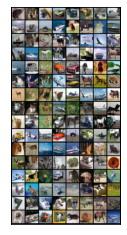

In [10]:
test_loop(
    test_loader=test_loader,
    model=model,
    device=device,
    metric_fn=accuracy,
    plot=True,
    loss_fn=F.cross_entropy,
)